# Use case: Crystal gel data

Experimental data from a crystallizing gel. See Tsurusawa, Nature Materials (2017) doi:10.1038/nmat4945

All distances are in pixels. Particle radius is 5.737px and they interact within 12.5 px.

In [1]:
import numpy as np
from scipy.spatial import cKDTree as KDTree
import boo
#from boo import boo
from matplotlib import pyplot as plt
from matplotlib import ticker
%matplotlib inline

## Prepare input

load coordinates

In [2]:
pos = np.loadtxt('AR-Res06A_scan2_t890.xyz', skiprows=1)
pos.shape

(28082, 3)

Construct the bond network. Here we know that particles interact when they are withon 12.5 px from each other. We thus use a maximum distance criteria. The use of a KDTree spatial indexing allows fast spatial queries to rerieve all particle pairs within 12.5 px of each other.

In [3]:
maxbondlength = 12.5
#spatial indexing
tree = KDTree(pos, 12)
#query
bonds = tree.query_pairs(maxbondlength, output_type='ndarray')
bonds.shape

(110120, 2)

Particles that are closer than 12.5 px to any edge of the experimental window are probably missing some neighbours. Also the bond order parameter is difficult to define for gas particles (3 neighbours or less).

In [4]:
inside = np.min((pos - pos.min(0) > maxbondlength) & (pos.max() - pos > maxbondlength), -1)
#number of neighbours per particle
Nngb = np.zeros(len(pos), int)
np.add.at(Nngb, bonds.ravel(), 1)
inside[Nngb<4] = False

Display a thin slice 

*This is really a quick but dirtyc way of showing the data in real space. Do not use this for a publication.*

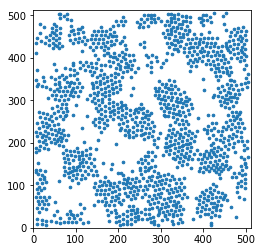

In [5]:
z0 = 100
sl = (pos[:,-1] > z0 - maxbondlength / 2) & (pos[:,-1] < z0 + maxbondlength / 2)
markersize = 7
plt.scatter(pos[sl,0], pos[sl,1], s=markersize, marker='o')

plt.xlim(0,512)
plt.ylim(0,512)
plt.axes().set_aspect('equal', 'box')

## tensorial bond orientational order

We focus on 6-fold and 4-fold orientational order

In [6]:
q6m = boo.bonds2qlm(pos, bonds, l=6)
q4m = boo.bonds2qlm(pos, bonds, l=4)

These can be coarse grained

In [7]:
Q6m, inside2 = boo.coarsegrain_qlm(q6m, bonds, inside)
Q4m, inside2 = boo.coarsegrain_qlm(q4m, bonds, inside)

## Crystals

We identify crystal particles as having at least 7 crystalline bonds (default value)

In [8]:
xpos = boo.x_particles(q6m, bonds)
xpos.mean()

0.41279111174417776

We can lower the threshold in the number of crystalline bonds to catch the surface of the crystal

In [9]:
surf = boo.x_particles(q6m, bonds, nb_thr=2) & np.bitwise_not(xpos)
surf.mean()

0.38636849227263015

Display a thin slice with colors that depend on the local structure around each particle

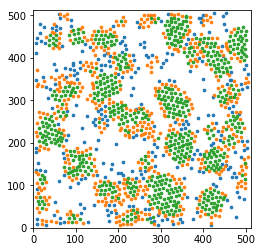

In [10]:
z0 = 100
sl = (pos[:,-1] > z0 - maxbondlength / 2) & (pos[:,-1] < z0 + maxbondlength / 2)
markersize = 7
for label, subset in zip(['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.scatter(pos[sl&subset,0], pos[sl&subset,1], s=markersize, marker='o', label=label)

plt.xlim(0,512)
plt.ylim(0,512)
plt.axes().set_aspect('equal', 'box')

## Rotational invarients

Rotational invarients give more precise information about the type of structures. However a sigle quantity if often not enough. That is why we often plot 2D maps.

In [11]:
q6 = boo.ql(q6m)
q4 = boo.ql(q4m)

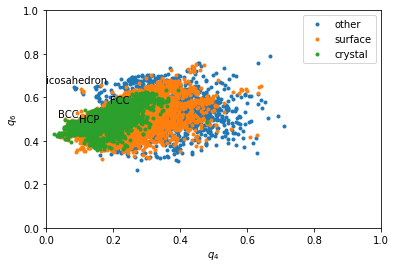

In [12]:
for label, subset in zip(['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.plot(q4[inside&subset], q6[inside&subset], '.', label=label)
plt.xlabel('$q_4$')
plt.ylabel('$q_6$')
plt.xlim(0,1)
plt.ylim(0,1)
plt.text(0.1909, 0.5745, 'FCC')
plt.text(0.0972, 0.4848, 'HCP')
plt.text(0.0364, 0.5107, 'BCC')
plt.text(0, 0.6633, 'icosahedron')
plt.legend()

/home/mathieu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


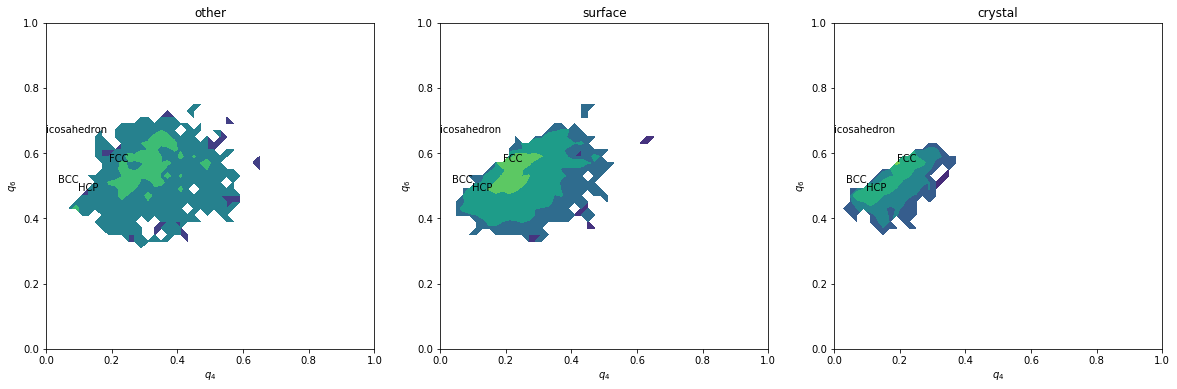

In [13]:
plt.figure(figsize=(20,6))
for i, label, subset in zip(range(3), ['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.subplot(1,3,i+1)
    H, xedges, yedges = np.histogram2d(q6[inside&subset], q4[inside&subset], range=[[0,1.0], [0.,1.0]], bins=(50, 50))
    plt.contourf(H, locator=ticker.LogLocator(), origin='lower', extent=(0,1,0,1))
    plt.title(label)
    plt.xlabel('$q_4$')
    plt.ylabel('$q_6$')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.text(0.1909, 0.5745, 'FCC')
    plt.text(0.0972, 0.4848, 'HCP')
    plt.text(0.0364, 0.5107, 'BCC')
    plt.text(0, 0.6633, 'icosahedron')

Without coarse graining, data is too noisy, even if the above maps could be refined by summing many time steps.

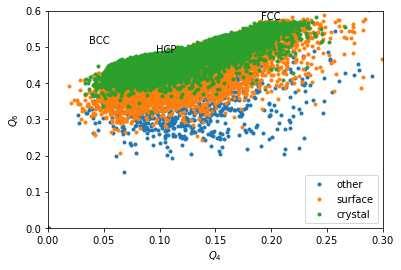

In [14]:
Q6 = boo.ql(Q6m)
Q4 = boo.ql(Q4m)
for label, subset in zip(['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.plot(Q4[inside&subset], Q6[inside&subset], '.', label=label)

plt.xlabel('$Q_4$')
plt.ylabel('$Q_6$')
plt.xlim(0,0.3)
plt.ylim(0,0.6)
plt.text(0.1909, 0.5745, 'FCC')
plt.text(0.0972, 0.4848, 'HCP')
plt.text(0.0364, 0.5107, 'BCC')
plt.legend()

/home/mathieu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


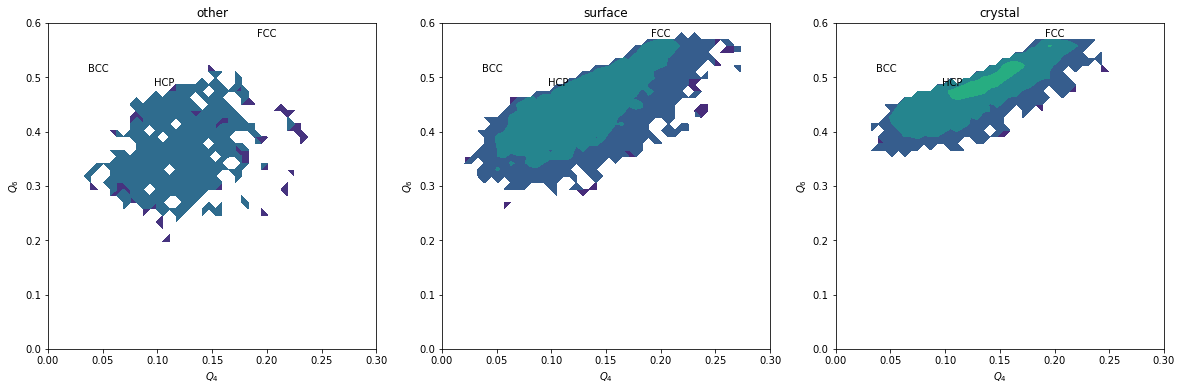

In [15]:
plt.figure(figsize=(20,6))
for i, label, subset in zip(range(3), ['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.subplot(1,3,i+1)
    H, xedges, yedges = np.histogram2d(Q6[inside&subset], Q4[inside&subset], range=[[0, 0.6], [0., 0.3]], bins=(50, 50))
    plt.contourf(H, locator=ticker.LogLocator(), origin='lower', extent=(0, 0.3, 0, 0.6))
    plt.title(label)
    plt.xlabel('$Q_4$')
    plt.ylabel('$Q_6$')
    plt.xlim(0,0.3)
    plt.ylim(0,0.6)
    plt.text(0.1909, 0.5745, 'FCC')
    plt.text(0.0972, 0.4848, 'HCP')
    plt.text(0.0364, 0.5107, 'BCC')

We can completely exclude BCC. Our crystals are a mixture of FCC and HCP.

Coarse graining basically erases the signal from icosahedral structures. $w_6$ makes icosahedron pop out as very negative values.

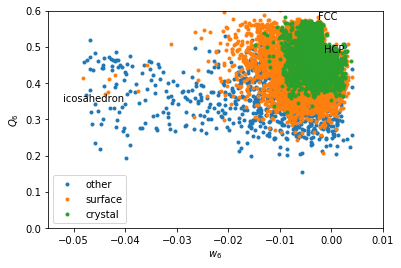

In [16]:
w6 = boo.wl(q6m)
for label, subset in zip(['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.plot(w6[inside2&subset], Q6[inside2&subset], '.', label=label)

plt.xlabel('$w_6$')
plt.ylabel('$Q_6$')
plt.xlim(-0.055, 0.01)
plt.ylim(0,0.6)
plt.text(-0.002626, 0.5745, 'FCC')
plt.text(-0.00149, 0.4848, 'HCP')
plt.text(-0.05213, 0.35, 'icosahedron')
plt.legend()

/home/mathieu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


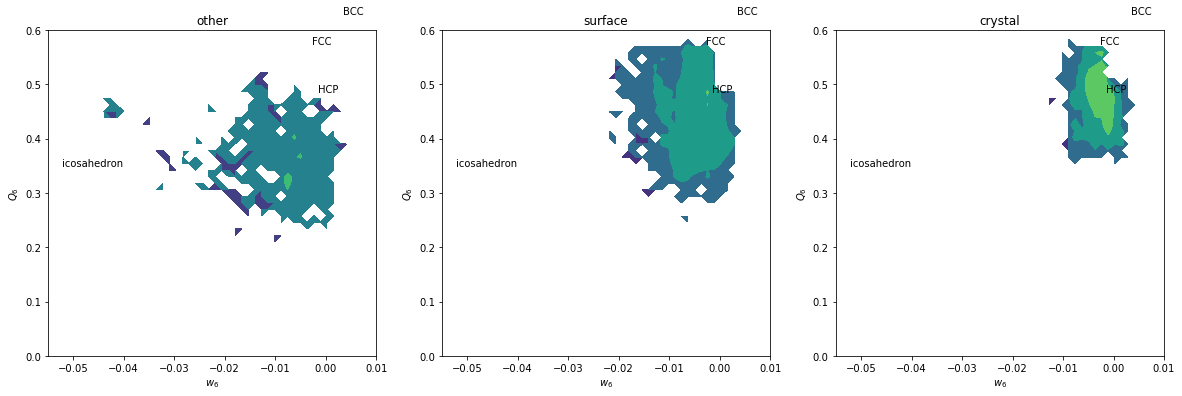

In [17]:
plt.figure(figsize=(20,6))
for i, label, subset in zip(range(3), ['other', 'surface', 'crystal'], [np.bitwise_not(xpos|surf), surf, xpos]):
    plt.subplot(1,3,i+1)
    H, xedges, yedges = np.histogram2d(Q6[inside&subset], w6[inside&subset], range=[[0, 0.6], [-0.055, 0.01]], bins=(50, 50))
    plt.contourf(H, locator=ticker.LogLocator(), origin='lower', extent=(-0.055, 0.01, 0, 0.6))
    plt.title(label)
    plt.xlabel('$w_6$')
    plt.ylabel('$Q_6$')
    plt.xlim(-0.055, 0.01)
    plt.ylim(0,0.6)
    plt.text(-0.002626, 0.5745, 'FCC')
    plt.text(-0.00149, 0.4848, 'HCP')
    plt.text(0.0034, 0.6285, 'BCC')
    plt.text(-0.05213, 0.35, 'icosahedron')

## Spatial correlation

This calculation can be long and heavy in memory if you take a large maximum distance

In [25]:
maxdist = 30
bounds = np.vstack((pos[inside2].min(0)+maxdist, pos[inside2].max(0)-maxdist))
is_center = (pos>bounds[0]).min(1) & (pos<bounds[1]).min(1)
is_center &= inside2
hqQ, g = boo.gG_l(pos, (q6m, Q6m), is_center, 1000, maxdist)

As a bonus, g can be converted into the pair distribution function $g(r)$.

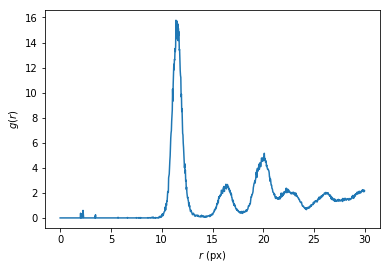

In [26]:
rs = np.arange(1000)*maxdist/1000
volume = np.prod(np.diff(bounds+[[-maxdist],[maxdist]], axis=0))
density = inside2.sum()/volume
shell_volume = (4*np.pi/3 * np.diff((np.arange(1001)*maxdist/1000.)**3))
plt.plot(rs, g/shell_volume/is_center.sum()/density)
plt.xlabel('$r$ (px)')
plt.ylabel('$g(r)$')

However, what we are really interested in is the spatial correlation of the bond orientational order.

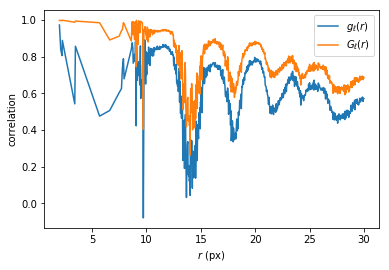

In [27]:
good = g>0
plt.plot(rs[good], hqQ[good,0]/g[good], label='$g_\ell(r)$')
plt.plot(rs[good], hqQ[good,1]/g[good], label='$G_\ell(r)$')
plt.xlabel('$r$ (px)')
plt.ylabel('correlation')
plt.legend()

To average the results on different frames, it is better to sum the outputs of `gG_l` and perform the divisions at the end.